# <font color='460C5F'> Pytemoics Practice: Pre-Genentech Internship <br> Sarah Kurpiers </font>

### The following notebook uses python & Pyteomics to: 
1.find and open/read a thermo-fisher .raw 'peptide map' data file, 2. read in a fasta file with one protein sequence, 3. 'digest' the sequence with trypsin, 4. calculate the masses of tryptic peptides, 5. calculate the mass-to-charge of all tryptic peptides assuming that they are ionized with +1 to +3 charge states, 6. "Search" the peptide map data for each ion, 7. answer 'how many of the amino acids (% of total) in your protein did you identify?', 8. answer 'does this % change if you use a different file?'

In [1]:
import os
from urllib.request import urlretrieve
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyteomics import fasta, parser, mass, achrom, electrochem, auxiliary, mzml, mzxml

The following fasta code is based on Pyteomics Example 1: https://pyteomics.readthedocs.io/en/stable/examples/example_fasta.html

### <font color='blue'> 1) Find and open/read a thermo-fisher .raw 'peptide map' data file </font>

## Raw MS data: Undepleted Human Serum
from: https://www.sciencedirect.com/science/article/pii/S2352340920305515

In [2]:
# Read in file and headings of data
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/pyteomics-practice/Files/Undepleted Human Serum.mzXML') as reader:
    auxiliary.print_tree(next(reader))

num
msLevel
peaksCount
polarity
scanType
filterLine
retentionTime
lowMz
highMz
basePeakMz
basePeakIntensity
totIonCurrent
id
m/z array
intensity array


In [3]:
# Read full data into dictionary
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/pyteomics-practice/Files/Undepleted Human Serum.mzXML') as spectra:
    spectrum = next(reader)
spectrum;

In [4]:
column_list = []
for key in spectrum:
    column_list.append(key)

# convert byte order for np.array entries
# fixed error "Big-endian buffer not supported on little-endian compiler"
spectrum['m/z array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['intensity array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['m/z array'] = spectrum['m/z array'].astype(np.float64)
spectrum['intensity array'] = spectrum['m/z array'].astype(np.float64)
spectrum['m/z array'] = spectrum['m/z array'].astype(str)
spectrum['intensity array'] = spectrum['m/z array'].astype(str)

In [5]:
# Create dataframe for undepleted human serum MS data
humandf = pd.DataFrame(spectrum)
humandf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,354.90338134765625,354.90338134765625
1,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,355.069091796875,355.069091796875
2,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,356.06805419921875,356.06805419921875
3,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0489196777344,357.0489196777344
4,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0660705566406,357.0660705566406
5,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0722351074219,357.0722351074219
6,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.4356689453125,357.4356689453125
7,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.9277038574219,357.9277038574219
8,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0479736328125,358.0479736328125
9,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0645751953125,358.0645751953125


## Protein 1: Comparing Raw data to Serum Albumin 
Data from: https://www.uniprot.org/uniprot/Q56G89

### <font color='blue'> 2) Read in a fasta file with just one protein sequence <br><br> 3) 'Digest' the sequence with trypsin </font> 

In [6]:
# Cleave entire set of proteins and count number of sequences
print('Cleaving the proteins with trypsin...')
unique_peptides1 = set()
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/pyteomics-practice/Files/Serum_Albumin.fasta') as serum:
    for descr, seq in serum:
        new_peptides1 = parser.cleave(seq, parser.expasy_rules['trypsin'])
        unique_peptides1.update(new_peptides1)
print('Done, {0} sequences obtained!'.format(len(unique_peptides1)))

Cleaving the proteins with trypsin...
Done, 73 sequences obtained!


In [7]:
# Create dict of peptides
peptides1 = [{'sequence': i} for i in unique_peptides1]
peptides1;

### <font color='blue'> 4) Calculate the masses of tryptic peptides  </font> 

In [8]:
# Calculate the masses of tryptic peptides
for peptide in peptides1:
    peptide['parsed_sequence'] = parser.parse(peptide['sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass1 = pd.DataFrame(peptides1)
columns_to_keep = ['sequence', 'mass']
peptidemass1 = peptidemass1[columns_to_keep]
peptidemass1 = peptidemass1.set_index('sequence')
peptidemass1.head(4)

,mass
sequence,
R,174.111676
LDELR,644.349340
VTK,346.221620
DLGEENFK,950.434526


### <font color='blue'> 5) Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states  </font> 

In [9]:
# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states
for peptide in peptides1:
    peptide['parsed_sequence'] = parser.parse(peptide['sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['m/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['m/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['m/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz1 = pd.DataFrame(peptides1)
columns_to_keep = ['sequence', 'mass', 'm/z +1 charge state', 'm/z +2 charge state', 'm/z +3 charge state']
peptidemz1 = peptidemz1[columns_to_keep]
peptidemz1 = peptidemz1.set_index('sequence')
peptidemz1.head(4)

,mass,m/z +1 charge state,m/z +2 charge state,m/z +3 charge state
sequence,,,,
R,174.111676,175.118952,88.063114,59.044502
LDELR,644.349340,645.356616,323.181946,215.790390
VTK,346.221620,347.228897,174.118087,116.414483
DLGEENFK,950.434526,951.441802,476.224539,317.818785


### <font color='blue'> 6) 'Search' the peptide map data for each ion </font>  

In [10]:
# Create lists of peptide fragments from fasta & round numbers to make search more forgiving
ionlist1_1 = peptidemz1['m/z +1 charge state'].tolist()
ionlist1_rounded_1 = [ '%.1f' % elem for elem in ionlist1_1 ]

ionlist1_2 = peptidemz1['m/z +2 charge state'].tolist()
ionlist1_rounded_2 = [ '%.1f' % elem for elem in ionlist1_2 ]

ionlist1_3 = peptidemz1['m/z +3 charge state'].tolist()
ionlist1_rounded_3 = [ '%.1f' % elem for elem in ionlist1_3 ]

In [26]:
ionlist1_rounded_3;

In [11]:
# Create new dataframe, add entries where fasta ions match raw data ions

# +1 charge state:
searchdf1_1 = pd.DataFrame()
for i in ionlist1_rounded_1:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf1_1 = pd.concat([searchdf1_1, iondf])
    
# +2 charge state
searchdf1_2 = pd.DataFrame()
for i in ionlist1_rounded_2:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf1_2 = pd.concat([searchdf1_2, iondf])
    
# +3 charge state
searchdf1_3 = pd.DataFrame()
for i in ionlist1_rounded_3:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf1_3 = pd.concat([searchdf1_3, iondf])
    
searchdf1_1

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
77,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,391.28338623046875,391.28338623046875
73,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,388.34149169921875,388.34149169921875


In [20]:
# Search for these similar ions in fasta to get sequence
i = 0
[r,c] = searchdf1_1.shape
sameion = []
while i < r:
    sameion.append(searchdf1_1.iloc[i]['m/z array'])
    i = i+1
for i in range(0, len(sameion)): 
    sameion[i] = int(float(sameion[i])) 
sameion_rounded = [ '%.0f' % elem for elem in sameion ]
sameion_rounded

peptidemz1['m/z +1 charge state'] = peptidemz1['m/z +1 charge state'].astype(str)
fastasearch = pd.DataFrame()
for i in sameion_rounded:
    iondf = peptidemz1.loc[peptidemz1['m/z +1 charge state'].str.match(i)]
    fastasearch = pd.concat([fastasearch, iondf])
fastasearch

,mass,m/z +1 charge state,m/z +2 charge state,m/z +3 charge state
sequence,,,,
FPK,390.226705,391.23398192631,196.120629,131.082845
QIK,387.248169,388.25544564688,194.631361,130.090000


In [12]:
searchdf1_2

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


In [22]:
searchdf1_3

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
187,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,462.9282531738281,462.9282531738281


In [32]:
# Search for these similar ions in fasta to get sequence
i = 0
[r,c] = searchdf1_3.shape
sameion3 = []
while i < r:
    sameion3.append(searchdf1_3.iloc[i]['m/z array'])
    i = i+1
for i in range(0, len(sameion3)): 
    sameion3[i] = int(float(sameion3[i])) 
sameion_rounded3 = [ '%.1f' % elem for elem in sameion3 ]

peptidemz1['m/z +3 charge state'] = peptidemz1['m/z +3 charge state'].astype(str)
fastasearch = pd.DataFrame()
for i in sameion_rounded:
    iondf = peptidemz1.loc[peptidemz1['m/z +3 charge state'].str.match(i)]
    fastasearch = pd.concat([fastasearch, iondf])
fastasearch

,mass,m/z +1 charge state,m/z +2 charge state,m/z +3 charge state
sequence,,,,
TCVADESAENCDK,1383.528245,1384.5355217537199,692.771399,462.18335822908665
YICENQDSISSK,1385.613295,1386.6205717070197,693.813924,462.8783748801866


<font color='red'> Conclusion: Three ions match partially between the human serum albumin database and undepleted human serum data. These sequences in the fasta are FPK, QIK, and TCVADESAENCDK or YICENQDSISSK. </font>

### <font color='blue'> 7) How many amino acids (% of total) are in the protein? </font>  

In [15]:
# How many amino acids (% of total) are in the protein?

# Determine amino acod composition
aacomp1 = parser.amino_acid_composition(seq)
aacomp1

# Split dictionary into keys and values
aakeys1 = aacomp1.keys() 
aavalues1 = aacomp1.values()

# Sreate DataFrame for amino acids in protein
aacompdf1 = pd.DataFrame(aavalues1, index = aakeys1)
aacompdf1 = aacompdf1.rename_axis('Serum Albumin Amino Acids')
aacompdf1 = aacompdf1.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf1['% of Total'] = (aacompdf1['Number of Residues'])/(aacompdf1['Number of Residues'].sum())*100
aacompdf1.head(4)

,Number of Residues,% of Total
Serum Albumin Amino Acids,,
M,7,1.149425
K,60,9.852217
W,2,0.328407
V,42,6.896552


### <font color='blue'> 8) Does this % change if you use a different file? </font>  

Yes, the % of each amino acid changes using different files. See below:

# Additional Examples: other proteins

## Protein 2: Comparing Raw data to Alpha-fetoprotein 
Data from: https://www.uniprot.org/uniprot/J3KMX3
The undepleted human serum ions are now compared to Alpha-fetoprotein, an evolutionarily similar protein to the albumin family.

In [16]:
# Cleave entire set of proteins and count number of sequences
print('Cleaving the proteins with trypsin...')
unique_peptides2 = set()
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/pyteomics-practice/Files/AFP.fasta') as afp:
    for descr, seq in afp:
        new_peptides2 = parser.cleave(seq, parser.expasy_rules['trypsin'])
        unique_peptides2.update(new_peptides2)
print('Done, {0} sequences obtained!'.format(len(unique_peptides2)))

Cleaving the proteins with trypsin...
Done, 56 sequences obtained!


In [17]:
# Create dict of peptides
peptides2 = [{'sequence': i} for i in unique_peptides2]
peptides2;

# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states
for peptide in peptides2:
    peptide['parsed_sequence'] = parser.parse(peptide['sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['m/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['m/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['m/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz2 = pd.DataFrame(peptides2)
columns_to_keep = ['sequence', 'mass', 'm/z +1 charge state', 'm/z +2 charge state', 'm/z +3 charge state']
peptidemz2 = peptidemz2[columns_to_keep]
peptidemz2 = peptidemz2.set_index('sequence')
peptidemz2.head(4)

,mass,m/z +1 charge state,m/z +2 charge state,m/z +3 charge state
sequence,,,,
TLHR,525.302330,526.309606,263.658441,176.108053
MK,277.146013,278.153289,139.580283,93.389281
FTK,394.221620,395.228897,198.118087,132.414483
LVLDVAHVHEHCCR,1629.786800,1630.794077,815.900677,544.269543


In [18]:
# Search AFP fasta against Undepleted Human Serum

# Create lists of peptide fragments from fasta & round numbers to make search more forgiving
ionlist2_1 = peptidemz2['m/z +1 charge state'].tolist()
ionlist2_rounded_1 = [ '%.1f' % elem for elem in ionlist2_1 ]

ionlist2_2 = peptidemz2['m/z +2 charge state'].tolist()
ionlist2_rounded_2 = [ '%.1f' % elem for elem in ionlist2_2 ]

ionlist2_3 = peptidemz2['m/z +3 charge state'].tolist()
ionlist2_rounded_3 = [ '%.1f' % elem for elem in ionlist2_3 ]

# Create new dataframe, add entries where fasta ions match raw data ions

# +1 charge state:
searchdf2_1 = pd.DataFrame()
for i in ionlist2_rounded_1:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf2_1 = pd.concat([searchdf2_1, iondf])
    
# +2 charge state
searchdf2_2 = pd.DataFrame()
for i in ionlist2_rounded_2:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf2_2 = pd.concat([searchdf2_2, iondf])
    
# +3 charge state
searchdf2_3 = pd.DataFrame()
for i in ionlist2_rounded_3:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf2_3 = pd.concat([searchdf2_3, iondf])
    
searchdf2_1

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


In [19]:
searchdf2_2

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


In [20]:
searchdf2_3

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
273,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,590.3878173828125,590.3878173828125


<font color = 'red'> Conclusion: Alpha-fetoprotein, a blood transport protein that is evolutionarliy similar to the albumin family has one similar ion to the raw undepelted human serum data. </font>

In [21]:
# How many amino acids (% of total) are in the protein?

# Determine amino acod composition
aacomp2 = parser.amino_acid_composition(seq)
aacomp2

# Split dictionary into keys and values
aakeys2 = aacomp2.keys() 
aavalues2 = aacomp2.values()

# Sreate DataFrame for amino acids in protein
aacompdf2 = pd.DataFrame(aavalues2, index = aakeys2)
aacompdf2 = aacompdf2.rename_axis('Alpha-fetoprotein Amino Acids')
aacompdf2 = aacompdf2.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf2['% of Total'] = (aacompdf2['Number of Residues'])/(aacompdf2['Number of Residues'].sum())*100
aacompdf2.head(4)

,Number of Residues,% of Total
Alpha-fetoprotein Amino Acids,,
M,9,1.446945
K,41,6.591640
W,2,0.321543
V,30,4.823151


## Protein 3: Comparing Raw data to Baker's Yeast proteome - single out first protein
Data from: https://www.uniprot.org/proteomes/UP000002311
I chose the first sequence from the Baker's yeast proteome by indexing a dataframe of all of the sequences.

In [22]:
unique_proteins3 = []
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/pyteomics-practice/Files/yeast.fasta') as yeast:
    for descr, seq in yeast:
        unique_proteins3.append(seq)
proteindf3 = pd.DataFrame(unique_proteins3, columns = ['Sequence'])
protein3 = proteindf3.iloc[0,0]
protein3

'MAILLPLKSILPWCCITFSFLLSSSGSISHSTASSSITLTKSSKPTNVPSNSRFDCSTINTFWLIVLSMTSKGKISGRLILRASVYACECTCIRYACCETIYPPRKPFSLSLYFFYFNKKASILFCYPDAKTKPEHPGNKRAGSG'

In [23]:
# 'Digest' the sequence with trypsin
unique_peptides3 = set()
new_peptides3 = parser.cleave(protein3, parser.expasy_rules['trypsin'])
unique_peptides3.update(new_peptides3)
unique_peptides3

{'AGSG',
 'ASILFCYPDAK',
 'ASVYACECTCIR',
 'FDCSTINTFWLIVLSMTSK',
 'GK',
 'ISGR',
 'K',
 'KPFSLSLYFFYFNK',
 'LILR',
 'MAILLPLK',
 'R',
 'SILPWCCITFSFLLSSSGSISHSTASSSITLTK',
 'SSKPTNVPSNSR',
 'TKPEHPGNK',
 'YACCETIYPPR'}

In [24]:
# Create dict of peptides
peptides3 = [{'sequence': i} for i in unique_peptides3]
peptides3;

# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states
for peptide in peptides3:
    peptide['parsed_sequence'] = parser.parse(peptide['sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['m/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['m/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['m/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz3 = pd.DataFrame(peptides3)
columns_to_keep = ['sequence', 'mass', 'm/z +1 charge state', 'm/z +2 charge state', 'm/z +3 charge state']
peptidemz3 = peptidemz3[columns_to_keep]
peptidemz3 = peptidemz3.set_index('sequence')
peptidemz3.head(4)

,mass,m/z +1 charge state,m/z +2 charge state,m/z +3 charge state
sequence,,,,
LILR,513.363868,514.371144,257.689210,172.128566
YACCETIYPPR,1314.573679,1315.580956,658.294116,439.198503
KPFSLSLYFFYFNK,1799.928679,1800.935956,900.971616,600.983503
ASILFCYPDAK,1226.600546,1227.607822,614.307549,409.874125


In [26]:
# Search Yeast fasta against Undepleted Human Serum

# Create lists of peptide fragments from fasta & round numbers to make search more forgiving
ionlist3_1 = peptidemz3['m/z +1 charge state'].tolist()
ionlist3_rounded_1 = [ '%.1f' % elem for elem in ionlist3_1 ]

ionlist3_2 = peptidemz3['m/z +2 charge state'].tolist()
ionlist3_rounded_2 = [ '%.1f' % elem for elem in ionlist3_2 ]

ionlist3_3 = peptidemz3['m/z +3 charge state'].tolist()
ionlist3_rounded_3 = [ '%.1f' % elem for elem in ionlist3_3 ]

# Create new dataframe, add entries where fasta ions match raw data ions

# +1 charge state:
searchdf3_1 = pd.DataFrame()
for i in ionlist3_rounded_1:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf3_1 = pd.concat([searchdf3_1, iondf])
    
# +2 charge state
searchdf3_2 = pd.DataFrame()
for i in ionlist3_rounded_2:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf3_2 = pd.concat([searchdf3_2, iondf])
    
# +3 charge state
searchdf3_3 = pd.DataFrame()
for i in ionlist3_rounded_3:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf3_3 = pd.concat([searchdf3_3, iondf])
    
searchdf3_1

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
230,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,514.415771484375,514.415771484375


In [27]:
searchdf3_2

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


In [28]:
searchdf3_3

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


<font color='red'> Conclusion: The first protein in Baker's Yeast has one similar ion to the raw undepelted human serum data. </font>

In [29]:
# How many amino acids (% of total) are in the protein?

# Determine amino acod composition
aacomp3 = parser.amino_acid_composition(seq)
aacomp3

# Split dictionary into keys and values
aakeys3 = aacomp3.keys() 
aavalues3 = aacomp3.values()

# Sreate DataFrame for amino acids in protein
aacompdf3 = pd.DataFrame(aavalues3, index = aakeys3)
aacompdf3 = aacompdf3.rename_axis('Yeast Protein 1 Amino Acids')
aacompdf3 = aacompdf3.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf3['% of Total'] = (aacompdf3['Number of Residues'])/(aacompdf3['Number of Residues'].sum())*100
aacompdf3.head(4)

,Number of Residues,% of Total
Yeast Protein 1 Amino Acids,,
M,9,7.03125
Y,22,17.18750
I,21,16.40625
F,11,8.59375


## Protein 4: Comparing Raw data Acetyl-coenzyme A carboxylase carboxyl transferase subunit beta, chloroplastic
Data from: https://www.uniprot.org/uniprot/A6MML6

In [33]:
unique_proteins4 = []
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/pyteomics-practice/Files/A6MML6.fasta') as a6mml6:
    for descr, seq in a6mml6:
        unique_proteins4.append(seq)
proteindf4 = pd.DataFrame(unique_proteins4, columns = ['Sequence'])
protein4 = proteindf4.iloc[0,0]
protein4

'MEKWWWFNSILSNERLEHRYGLSKSMDSVNGIEYTKDPILNDTEKNILGWSDSSNYSFSTVDYLFEIRNIWSLISDDTFLVRDSNGDSYSVYFDIENQIFEIDNNSSFLGELESFFSSYLNRGSKNKYYHYMYDTQFSWNNHITNCIDSYLRFEIGISITSYISGDIVNYSDGYIYSFICTESVSSNESGSSSIRTSSNGSDFNMRENSNDSDINKKYRHLWVQCENCYGLNYKKFFRSKMNICEQCGYHLKMSSSDRIEVSIDPDTWDPMDEDMVSIDPIEFHSEEEPYRDRIDSYQRKTGLTEAIQTGIGQLNGIPIAIGVMDFQFMGGSMGSVVGEKITRLIEYATNESLPVIIVCASGGARMQEGSLSLMQMAKISSASYNYQSNKKLFYVSILTSPTTGGVTASFGMLGDVIIAEPNAYIAFAGKRVIEQTLNKTVPDGSQSAEYLFHKGLFDPIVPRNPLKGVLSELFQLHGFLPLNQNKKEN'

In [31]:
# 'Digest' the sequence with trypsin
unique_peptides4 = set()
new_peptides4 = parser.cleave(protein4, parser.expasy_rules['trypsin'])
unique_peptides4.update(new_peptides4)
unique_peptides4;

In [32]:
# Create dict of peptides
peptides4 = [{'sequence': i} for i in unique_peptides4]
peptides4;

# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states
for peptide in peptides4:
    peptide['parsed_sequence'] = parser.parse(peptide['sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['m/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['m/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['m/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz4 = pd.DataFrame(peptides4)
columns_to_keep = ['sequence', 'mass', 'm/z +1 charge state', 'm/z +2 charge state', 'm/z +3 charge state']
peptidemz4 = peptidemz4[columns_to_keep]
peptidemz4 = peptidemz4.set_index('sequence')
peptidemz4.head(4)

,mass,m/z +1 charge state,m/z +2 charge state,m/z +3 charge state
sequence,,,,
HLWVQCENCYGLNYK,1868.833810,1869.841087,935.424182,623.951880
TSSNGSDFNMR,1214.498600,1215.505876,608.256576,405.840143
GLFDPIVPR,1012.570566,1013.577842,507.292559,338.530798
ENSNDSDINK,1134.478910,1135.486186,568.246731,379.166913


In [33]:
# Search Yeast fasta against Undepleted Human Serum

# Create lists of peptide fragments from fasta & round numbers to make search more forgiving
ionlist4_1 = peptidemz4['m/z +1 charge state'].tolist()
ionlist4_rounded_1 = [ '%.1f' % elem for elem in ionlist4_1 ]

ionlist4_2 = peptidemz4['m/z +2 charge state'].tolist()
ionlist4_rounded_2 = [ '%.1f' % elem for elem in ionlist4_2 ]

ionlist4_3 = peptidemz4['m/z +3 charge state'].tolist()
ionlist4_rounded_3 = [ '%.1f' % elem for elem in ionlist4_3 ]

# Create new dataframe, add entries where fasta ions match raw data ions

# +1 charge state:
searchdf4_1 = pd.DataFrame()
for i in ionlist4_rounded_1:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf4_1 = pd.concat([searchdf4_1, iondf])
    
# +2 charge state
searchdf4_2 = pd.DataFrame()
for i in ionlist4_rounded_2:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf4_2 = pd.concat([searchdf4_2, iondf])
    
# +3 charge state
searchdf4_3 = pd.DataFrame()
for i in ionlist4_rounded_3:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf4_3 = pd.concat([searchdf4_3, iondf])
    
searchdf4_1

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
257,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,554.3988037109375,554.3988037109375


In [34]:
searchdf4_2

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
77,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,391.28338623046875,391.28338623046875


In [35]:
searchdf4_3

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


<font color='red'> Conclusion: A6MML6 has two similar ions to the raw undepelted human serum data.</font>

In [36]:
# How many amino acids (% of total) are in the protein?

# Determine amino acod composition
aacomp4 = parser.amino_acid_composition(seq)
aacomp4

# Split dictionary into keys and values
aakeys4 = aacomp4.keys() 
aavalues4 = aacomp4.values()

# Sreate DataFrame for amino acids in protein
aacompdf4 = pd.DataFrame(aavalues4, index = aakeys4)
aacompdf4 = aacompdf4.rename_axis('A6MML6 Amino Acids')
aacompdf4 = aacompdf4.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf4['% of Total'] = (aacompdf4['Number of Residues'])/(aacompdf4['Number of Residues'].sum())*100
aacompdf4.head(4)

,Number of Residues,% of Total
A6MML6 Amino Acids,,
M,15,3.067485
E,32,6.543967
K,23,4.703476
W,8,1.635992


## Additional Example: Analyze entire fasta file: Yeast

This sections analyzes the entire Fasta file for the Baker's yeast proteome - Saccharomyces cerevisiae (strain ATCC 204508 / S288c). Analysis is limited to sequences with less than 100 residues to save time. Future sections focus on just one protein. Here is the link to data used: https://www.uniprot.org/proteomes/UP000002311

In [37]:
# Cleave entire set of proteins and count number of sequences
print('Cleaving the proteins with trypsin...')
unique_peptides = set()
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/pyteomics-practice/Files/yeast.fasta') as yeast:
    for descr, seq in yeast:
        new_peptides = parser.cleave(seq, parser.expasy_rules['trypsin'])
        unique_peptides.update(new_peptides)
print('Done, {0} sequences obtained!'.format(len(unique_peptides)))

Cleaving the proteins with trypsin...
Done, 188694 sequences obtained!


In [38]:
# Create dict of peptides
peptides = [{'sequence': i} for i in unique_peptides]

# Pre-parse the sequence into individual amino acids, save terminal groups to take into account in mass & charge
# Add sequence and parsed sequence to dict
for peptide in peptides:
    peptide['parsed_sequence'] = parser.parse(peptide['sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    
# Limit to peptides with less than 100 residues
peptides = [peptide for peptide in peptides if peptide['length'] <= 100]

In [39]:
# Add properties to dict including: charge with pH = 2.0, mass, m/z, and 
# retention time in reversed and normal phase chromatography
for peptide in peptides:
    peptide['charge'] = int(round(electrochem.charge(peptide['parsed_sequence'], pH=2.0)))
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['m/z'] = mass.calculate_mass(peptide['parsed_sequence'], charge=peptide['charge'])
    peptide['RT_RP'] = achrom.calculate_RT(peptide['parsed_sequence'],achrom.RCs_zubarev)
    peptide['RT_normal'] = achrom.calculate_RT(peptide['parsed_sequence'],achrom.RCs_yoshida_lc)

# Create dataframe to store peptide properties in
peptidedf = pd.DataFrame.from_dict(peptides)
peptidedf.head(5)

,RT_RP,RT_normal,charge,length,m/z,mass,parsed_sequence,sequence
0,68.137758,9.474920,2,15,835.426913,1668.839272,"[H-, L, S, T, L, E, T, S, M, S, E, F, G, V, I,...",LSTLETSMSEFGVIR
1,35.458909,10.747606,2,6,381.683799,761.353045,"[H-, N, W, S, M, P, K, -OH]",NWSMPK
2,46.623685,4.228461,2,6,365.228897,728.443240,"[H-, E, L, L, L, N, K, -OH]",ELLLNK
3,31.681631,15.981425,3,9,346.521073,1036.541391,"[H-, V, L, A, H, E, A, Q, N, R, -OH]",VLAHEAQNR
4,60.711381,16.230710,2,19,1025.521253,2049.027953,"[H-, E, N, L, A, W, V, I, P, V, E, N, A, P, S,...",ENLAWVIPVENAPSGPSNR


### Search entire yeast proteome against human:


In [40]:
ionlist = peptidedf['m/z'].tolist()
ionlist_rounded = [ '%.1f' % elem for elem in ionlist ]
ionlist_rounded;

In [41]:
searchdf = pd.DataFrame()
for i in ionlist_rounded:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf = pd.concat([searchdf, iondf])
searchdf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
65,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,381.9936218261719,381.9936218261719
80,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,392.99017333984375,392.99017333984375
20,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,361.2210998535156,361.2210998535156
94,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,399.2496643066406,399.2496643066406
29,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,367.268798828125,367.268798828125
20,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,361.2210998535156,361.2210998535156
104,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,409.26995849609375,409.26995849609375
112,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,416.0350646972656,416.0350646972656
90,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,396.5106506347656,396.5106506347656
136,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,432.9177551269531,432.9177551269531


The above dataframe displays the ions similar between human undepleted serum and the entire yeast proteome.

# Seperate Algorithm:

## Pyteomics Example 2: Reading in a MGF file and comparing to pepXML identification info

In [50]:
from pyteomics import mgf, pepxml
import pylab

In [47]:
# Defines function that will give m/z of theoretical fragments for a given sequence. 
# pyteomics.mass.fast_mass() is used to calculate. The sequence is split at every bond and the function 
# iterates over possible charges and ion types

def fragments(peptide, types=('b', 'y'), maxcharge=3):
    """
    The function generates all possible m/z for fragments of types 
    `types` and of charges from 1 to `maxcharge`.
    """
    for i in xrange(1, len(peptide)-1):
        for ion_type in types:
            for charge in xrange(1, maxcharge+1):
                if ion_type[0] in 'abc':
                    yield mass.fast_mass(
                            peptide[:i], ion_type=ion_type, charge=charge)
                else:
                    yield mass.fast_mass(
                            peptide[i:], ion_type=ion_type, charge=charge)

In [44]:
with mgf.read('/Users/sarahkurpiers/Documents/Genentech/example.mgf') as spectra, pepxml.read('/Users/sarahkurpiers/Documents/Genentech/example.pep.xml') as psms:
    spectrum = next(spectra)
    psm = next(psms)
spectrum

{'params': {'title': 'GPAAIQK', 'pepmass': (342.70559, None), 'charge': [2]},
 'm/z array': array([155.08127, 176.77814, 177.11287, 226.11824, 229.64627, 265.16449,
        265.66641, 269.16089, 275.1712 , 297.15521, 314.19504, 314.69733,
        325.18619, 343.20746, 343.70929, 382.2438 , 388.25513, 389.25903,
        392.22888, 408.18784, 409.19104, 410.23959, 411.24402, 457.28772,
        459.29205, 460.29568, 493.27762, 513.3031 , 520.28723, 521.27124,
        522.27612, 530.32843, 531.33197, 532.33423, 536.24768, 538.29736,
        539.30054, 540.31415, 554.29248, 555.29999, 556.30743]),
 'intensity array': array([  2297.6,   7543.8,   2635.6,   5689.8,   5041.8,  17045.5,
          3543.8,   3408.9,   2846.8,   8410.6,   6265.5,   2129. ,
          3157.4,   4456.9,   4044.3,   3641.6,  42239.4,   6749.8,
          2317.6,   9400.2,   2566.7,  20488. ,   4645. ,   4824.5,
        139345.9,  35741.9,   3401.2,   6745.2,   2995.6,  10339.9,
          2187.7, 378102.2, 120362.4,   4

In [45]:
psm

{'spectrum': '',
 'precursor_neutral_mass': 683.3966,
 'assumed_charge': 2,
 'start_scan': 1,
 'end_scan': 1,
 'index': 1,
 'search_hit': [{'hit_rank': 1,
   'peptide': 'GPAAIQK',
   'num_tot_proteins': 1,
   'num_matched_ions': 8,
   'tot_num_ions': 12,
   'num_missed_cleavages': 0,
   'search_score': {'hyperscore': 23.2,
    'nextscore': 17.3,
    'bscore': 6.6,
    'yscore': 12.1,
    'cscore': 0.0,
    'zscore': 0.0,
    'ascore': 0.0,
    'xscore': 0.0,
    'expect': 1.3},
   'calc_neutral_pep_mass': 683.3966,
   'massdiff': 0.0,
   'is_rejected': False,
   'proteins': [{'protein': 'sp|P35527|K1C9_HUMAN',
     'protein_descr': 'Keratin, type I cytoskeletal 9 OS=Homo sapiens GN=KRT9 PE=1 SV=3',
     'peptide_next_aa': 'N',
     'peptide_prev_aa': 'K',
     'num_tol_term': 2}],
   'modified_peptide': 'GPAAIQK',
   'modifications': []}]}

<BarContainer object of 41 artists>

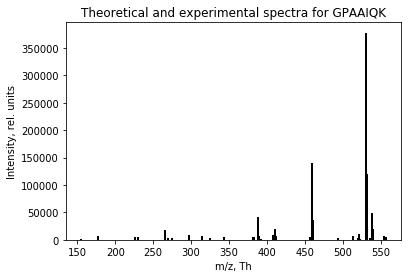

In [51]:
# Prepare figure
pylab.figure()
pylab.title('Theoretical and experimental spectra for '
        + psm['search_hit'][0]['peptide'])
pylab.xlabel('m/z, Th')
pylab.ylabel('Intensity, rel. units')

# Plot real spectrum
pylab.bar(spectrum['m/z array'], spectrum['intensity array'], width=0.1, linewidth=2,
        edgecolor='black')

In [55]:
try:
    # Python 2
    xrange
except NameError:
    # Python 3, xrange is now named range
    xrange = range

# Python 2 code that uses xrange(...) unchanged, and any
# range(...) replaced with list(range(...))

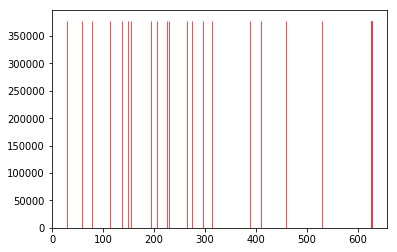

In [54]:
# The most intensive peaks in the spectrum are indeed matched by the theoretical spectrum
theor_spectrum = list(fragments(psm['search_hit'][0]['peptide'],
    maxcharge=psm['assumed_charge']))
pylab.bar(theor_spectrum,
        [spectrum['intensity array'].max()]*len(theor_spectrum),
        width=0.1, edgecolor='red', alpha=0.7)
pylab.show()